<a href="https://colab.research.google.com/github/raeubaen/RadioMonteCarlo/blob/main/XGBoost_RMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import os
import xgboost as xgb
import time

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

from sklearn.model_selection import train_test_split

np.random.seed() # shuffle random seed generator

!nvidia-smi

Wed Jun 22 13:10:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   1142MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
'''
# taglio solo a 50 MeV
!wget https://www.dropbox.com/s/qrv8y0l3wlcgx8f/bkg_etrn.npy?dl=1 -O bkg_etrn.npy
!wget https://www.dropbox.com/s/va1mo6um1al1l5r/signal_etrn.npy?dl=1 -O signal_etrn.npy
'''

# + taglio a R > 480 mm

!wget https://www.dropbox.com/s/fqxxodsx3xpe9ge/mnbs_etrn.npy?dl=1 -O bkg_etrn.npy

!wget https://www.dropbox.com/s/bto89w1z2knnak7/signal_etrn.npy?dl=1 -O signal_etrn.npy

--2022-06-22 12:35:46--  https://www.dropbox.com/s/fqxxodsx3xpe9ge/mnbs_etrn.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/fqxxodsx3xpe9ge/mnbs_etrn.npy [following]
--2022-06-22 12:35:46--  https://www.dropbox.com/s/dl/fqxxodsx3xpe9ge/mnbs_etrn.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0acd30db98ee52dcf585d1d38b.dl.dropboxusercontent.com/cd/0/get/BnpVy95eHP8i76TguFgZ8JNSNZeJWvMMIHIQx6A-5zdSl8DEmR2u_H_lVxIT4kW95rcN8JK5yQrL0ae_eSMEoxGQ65Pev5QH1jkbrZLEM_2Ipqbrcdpy6-fiL_O3F5tbKbUPvyAtxehP1-Ds0vyUuTZMAONjPcGJ7oFNzM-gyhXF_cbN6ot5uH7YSp4Y8ge-CvQ/file?dl=1# [following]
--2022-06-22 12:35:47--  https://uc0acd30db98ee52dcf585d1d38b.dl.dropboxusercontent.com/cd/0/get/BnpVy95eHP8i76TguFgZ8JNSNZeJWvMMIHIQx6A-5z

In [26]:
signal_numpy_data = np.load("signal_etrn.npy")
bkg_numpy_data = np.load("bkg_etrn.npy")

X = np.concatenate((signal_numpy_data, bkg_numpy_data))
Y = np.concatenate((np.ones(len(signal_numpy_data)), np.zeros(len(bkg_numpy_data))))

signal_weight = 330/150e3 * 100
mnbs_weight = 1.3/5.25 * 100

W = np.concatenate(
    [ np.ones((len(signal_numpy_data)))*signal_weight, np.ones((len(bkg_numpy_data)))*mnbs_weight ]
)

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

train_to_test_ratio = 0.1

X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(
    X, Y, W,
    train_size=train_to_test_ratio,
    test_size=1.0 - train_to_test_ratio
)

X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(
    X_train, Y_train, W_train,
    train_size=train_to_test_ratio,
    test_size=1.0 - train_to_test_ratio
)


X shape: (42504, 4)
Y shape: (42504,)


(array([4.3230e+03, 8.1040e+03, 1.0682e+04, 9.1250e+03, 5.4310e+03,
        3.3540e+03, 2.5100e+02, 7.6000e+01, 2.2000e+01, 4.0000e+00]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <a list of 10 Patch objects>)

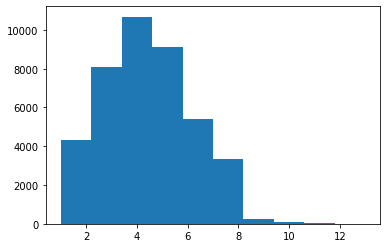

In [22]:
plt.hist(signal_numpy_data[:, 0])

In [4]:
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 231 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=5b09093eda614803a76eb1575278f44e2ca9fec6d69348655cd629b248958375
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AprC: 0.935275817094453


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


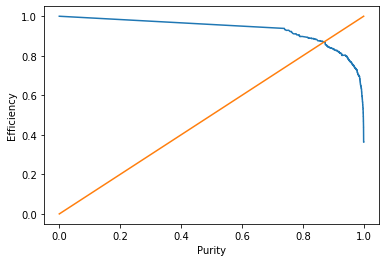

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AprC: 0.9243701120011535


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


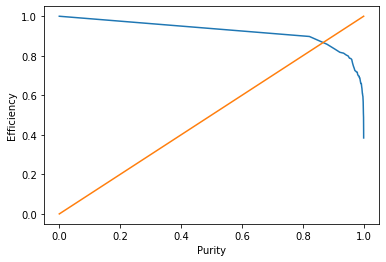

AprC: 0.8645652410967628


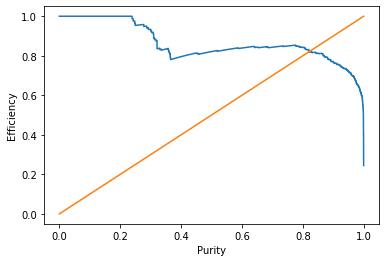

AprC: 0.8809059048063422


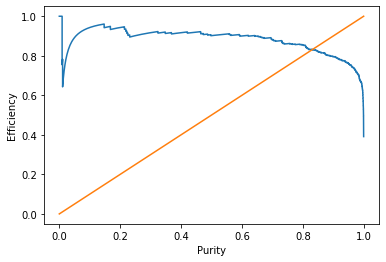

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont:

AprC: 0.6940377190263857


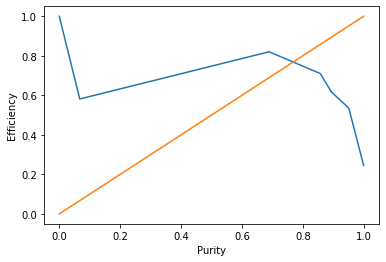

In [16]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from dtreeviz.trees import *

clf_dict = {
    RandomForestClassifier: dict(min_samples_split=10, n_estimators=200, warm_start=True, verbose=1),
    ExtraTreesClassifier: dict(n_estimators=200, verbose=1),
    AdaBoostClassifier: dict(n_estimators=200),
    HistGradientBoostingClassifier: dict(max_iter=200),
    DecisionTreeClassifier: dict(max_depth=3)
}

for clf in clf_dict:
  instance = clf(**clf_dict[clf])

  instance.fit(X_train, Y_train, sample_weight=W_train)

  probs = instance.predict_proba(X_test)[:, 1]

  if isinstance(instance, DecisionTreeClassifier):

    viz = dtreeviz(instance, X_test, Y_test,
                    target_name="target",
                    feature_names=["E", "T", "R"],
                    class_names=["S", "B"])

    viz.save("decision_tree.svg")

  prec, recall, thres = precision_recall_curve(Y_test, probs, sample_weight=W_test)
  print(f"AprC: {auc(recall, prec)}")
  plt.plot(recall, prec)
  plt.plot([0, 1], [0, 1])
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.ylabel("Purity")
  plt.xlabel("Efficiency")

  plt.show()

In [6]:
time_start = time.time()
xg_train = xgb.DMatrix(X_train, label=Y_train, weight=W_train)
xg_test = xgb.DMatrix(X_test, label=Y_test, weight=W_test)
xg_val = xgb.DMatrix(X_val, label=Y_val, weight=W_val)

param = {
    # use softmax multi-class classification
    # scale weight of positive examples
    'objective': 'binary:logistic',
    'n_estimators': 20,
    'max_depth': 5,
    'silent': 0,
    'gpu_id': 0,
    #'max_bin': 6,
    'tree_method': 'gpu_hist',
    "eval_metric": [
      "aucpr",
    ]
}

# watchlist allows us to monitor the evaluation result on all data in the list 
watchlist = [(xg_train, 'train'), (xg_val, 'val')]
num_round = 50

bst = xgb.train(param, xg_train, num_round, watchlist)

print(time.time() - time_start)


[0]	train-aucpr:0.95417	val-aucpr:0.825813
[1]	train-aucpr:0.965955	val-aucpr:0.843825
[2]	train-aucpr:0.982714	val-aucpr:0.868561
[3]	train-aucpr:0.985538	val-aucpr:0.869849
[4]	train-aucpr:0.988681	val-aucpr:0.87213
[5]	train-aucpr:0.990769	val-aucpr:0.876027
[6]	train-aucpr:0.992317	val-aucpr:0.885366
[7]	train-aucpr:0.994327	val-aucpr:0.896257
[8]	train-aucpr:0.995604	val-aucpr:0.902379
[9]	train-aucpr:0.996744	val-aucpr:0.906075
[10]	train-aucpr:0.996926	val-aucpr:0.910391
[11]	train-aucpr:0.997184	val-aucpr:0.91098
[12]	train-aucpr:0.99782	val-aucpr:0.916642
[13]	train-aucpr:0.998235	val-aucpr:0.917521
[14]	train-aucpr:0.99862	val-aucpr:0.916319
[15]	train-aucpr:0.998783	val-aucpr:0.90951
[16]	train-aucpr:0.998858	val-aucpr:0.912643
[17]	train-aucpr:0.998939	val-aucpr:0.908987
[18]	train-aucpr:0.999113	val-aucpr:0.910726
[19]	train-aucpr:0.999248	val-aucpr:0.906791
[20]	train-aucpr:0.999367	val-aucpr:0.90932
[21]	train-aucpr:0.999362	val-aucpr:0.912346
[22]	train-aucpr:0.999371	v

AUprC: 0.9136960331822366


Text(0, 0.5, 'Efficiency')

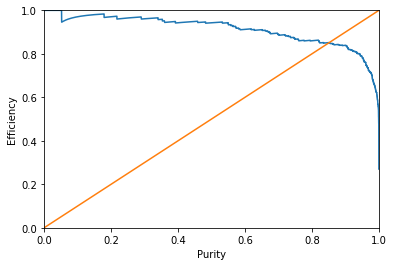

In [7]:
probs = bst.predict(xg_test)

prec, recall, thres = precision_recall_curve(Y_test, probs, sample_weight=W_test)

print(f"AUprC: {auc(recall, prec)}")

plt.plot(recall, prec)
plt.plot([0, 1], [0, 1])

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Purity")
plt.ylabel("Efficiency")